In [45]:
import zipfile
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torchaudio
import torchaudio.transforms as transforms
import torch.nn as nn
import numpy as np
import data
import time

path = './data/'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_fn = 'MelLoss'

In [46]:
# USE DIFFERENT PREPROCESSORS
class PreProcessor(torch.nn.Module):
    def __init__(
        self,
        input_samplerate = 16000,
        resample_samplerate = 16000,
        n_fft = 480,
        power=None
    ):
        super().__init__()
        self.output_size = (n_fft+2)//2
        self.resample = transforms.Resample(input_samplerate, resample_samplerate)
        self.transform = transforms.Spectrogram(n_fft=n_fft, power=power, window_fn=torch.hann_window, normalized=True, center=True)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        resampled = self.resample(waveform)
        spec = self.transform(resampled)
        spec = spec.permute(0, 2, 1)
        return spec


class PostProcessor(torch.nn.Module):
    def __init__(
        self,
        output_samplerate = 16000,
        resample_samplerate = 16000,
        n_fft = 480
    ):
        super().__init__()
        n_fft = n_fft
        self.resample = transforms.Resample(resample_samplerate, output_samplerate)
        self.transform = transforms.InverseSpectrogram(n_fft=n_fft, window_fn=torch.hann_window, normalized=True, center=True)

    def forward(self, spec: torch.Tensor) -> torch.Tensor:
        spec = spec.permute(0, 2, 1)
        waveform = self.transform(spec)
        resampled = self.resample(waveform)
        return resampled


In [47]:
class MelLoss(torch.nn.Module):
    def __init__(
        self,
        sample_rate,
        n_stft=101,
        n_mels=10,
        device='cpu'
    ):
        super().__init__()
        self.melscale_transform = torchaudio.functional.melscale_fbanks(
            n_stft,
            f_min = 0,
            f_max = sample_rate / 2.0,
            n_mels = n_mels,
            sample_rate = sample_rate,
            norm = 'slaney',
        ).to(device)

    def __str__(self):
        return "MelLoss"
        
    def forward(self, estimated_spec, reference_spec):        
        mel_error_spec = torch.matmul(            
            (estimated_spec - reference_spec).abs()**2,
            self.melscale_transform
        )
        return mel_error_spec.clamp(min=1e-6).log().mean(dim=-2).mean()
 
    
class MagMSELoss(torch.nn.Module):
    def __init__(
        self,
    ):
        super().__init__()
        self.mse_loss = nn.L1Loss()

    def __str__(self):
        return "MelLoss"
        
    def forward(self, estimated_spec, reference_spec):        
        loss = self.mse_loss(estimated_spec.abs(), reference_spec.abs())
        return loss.clamp(min=1e-6).mean()

In [48]:
def train(
    dataloader, 
    dataset, 
    model, 
    preprocessor, 
    loss_fn, 
    optimizer, 
    scheduler, 
    epochs=1,
):
    size = len(dataset)
    model.train()
    start_time = time.perf_counter()

    for epoch in range(epochs):
        flag = False

        for batch, (noisy_batch, clean_batch, _) in enumerate(dataloader):
            noisy_spec = preprocessor(noisy_batch).to(device)
            clean_spec = preprocessor(clean_batch).to(device)

            batch_size = noisy_batch.shape[0]

            est_clean_spec = model(noisy_spec)
            loss = loss_fn(est_clean_spec, clean_spec)
            
            scheduler.step(loss)

            if torch.isnan(loss) or torch.isinf(loss) or loss > 1e9:
                print(f"Encountered NaN loss at batch {batch}, skipping this batch.")
                flag = True
                break

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            if (batch+1) % 10 == 0:
                curr_time = time.perf_counter()
                loss, current = loss.item(), 1 + (batch)*batch_size + epoch*size
                print(f"loss: {loss:>7f} [{current:>5d}/{size*epochs:>5d}] at {curr_time-start_time:>5f} sec")
                start_time = curr_time

        if flag:
            break

In [49]:
class MagBLSTM(nn.Module):
    def __init__(
        self,
        n_fft=400,
        lstm_hidden_size=256,
        linear_hidden_size=512,
        lstm_layers=2,
        dropout=0.4,
        device='cpu',
        bidirectional=True
    ): 
        super().__init__()
        self.device = device      
        self.spec_size = n_fft // 2 + 1
        
        self.fc1 = nn.Linear(in_features=self.spec_size, out_features=linear_hidden_size)
        self.bn1 = nn.BatchNorm1d(num_features=linear_hidden_size)
        self.tanh1 = nn.Tanh()

        self.lstm = nn.LSTM(input_size=linear_hidden_size, hidden_size=lstm_hidden_size, num_layers=lstm_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)

        self.fc2 = nn.Linear(in_features=lstm_hidden_size * (2 ** int(bidirectional)), out_features=linear_hidden_size)
        self.bn2 = nn.BatchNorm1d(num_features=linear_hidden_size)
        self.relu1 = nn.ReLU()

        self.fc3 = nn.Linear(in_features=linear_hidden_size, out_features=self.spec_size)
        self.bn3 = nn.BatchNorm1d(num_features=self.spec_size)
        self.relu2 = nn.ReLU()

    def forward(self, input_spec: torch.Tensor):
        input_features = input_spec.abs()

        out = self.fc1(input_features)
        out = self.bn1(out.permute(0, 2, 1)).permute(0, 2, 1)
        out = self.tanh1(out)

        out, _ = self.lstm(out)
        
        out = self.fc2(out)
        out = self.bn2(out.permute(0, 2, 1)).permute(0, 2, 1)
        out = self.relu1(out)

        out = self.fc3(out)
        out = self.bn3(out.permute(0, 2, 1)).permute(0, 2, 1)
        gains = self.relu2(out)

        out = input_spec * gains
        return out

In [50]:
class BLSTM(nn.Module):
    def __init__(
        self,
        spec_size=101,
        n_mels=10,
        lstm_hidden_size=425,
        lstm_layers=3,
        attention_heads=1,
        input_samplerate=16000,
        dropout=0.4,
        device='cpu',
        bidirectional=False
    ): 
        super().__init__()
        self.device = device      
        self.melscale_transform = torchaudio.functional.melscale_fbanks(
            spec_size,
            f_min=0,
            f_max=input_samplerate / 2.0,
            n_mels=n_mels,
            sample_rate=input_samplerate,
            norm='slaney',
        )
        self.melscale_transform = self.melscale_transform.to(device)

        self.device = device
        self.spec_size = spec_size
        
        # YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=n_mels, out_features=425)
        self.bn1 = nn.BatchNorm1d(num_features=425)
        self.tanh1 = nn.Tanh()

        self.lstm = nn.LSTM(input_size=425, hidden_size=lstm_hidden_size, num_layers=lstm_layers, bidirectional=bidirectional, dropout=dropout)
        self.attention = nn.MultiheadAttention(embed_dim=425 + lstm_hidden_size * (2 ** int(bidirectional)), num_heads=attention_heads)
        self.fc2 = nn.Linear(in_features=425 + lstm_hidden_size * (2 ** int(bidirectional)), out_features=425)
        self.bn2 = nn.BatchNorm1d(num_features=425)
        self.relu1 = nn.ReLU()

        self.fc3 = nn.Linear(in_features=425, out_features=425)
        self.bn3 = nn.BatchNorm1d(num_features=425)
        self.relu2 = nn.ReLU()

        self.fc4 = nn.Linear(in_features=425, out_features=spec_size)
        self.bn4 = nn.BatchNorm1d(num_features=spec_size)
        self.relu3 = nn.ReLU()

    def eval(self):
        self.eval_state = True
        return
    
    def train(self):
        self.eval_state = False
        return

    def forward(self, input_spec: torch.Tensor):
        input_features = torch.matmul(
            input_spec.abs()**2,
            self.melscale_transform
        )

        out = self.fc1(input_features)
        out = self.bn1(out.permute(0, 2, 1)).permute(0, 2, 1)
        out = self.tanh1(out)

        out_skip1 = out.clone()

        out, _ = self.lstm(out)
        out = torch.cat((out, out_skip1), dim=-1)
        out, _ = self.attention(out, out, out)
        
        out = self.fc2(out)
        out = self.bn2(out.permute(0, 2, 1)).permute(0, 2, 1)
        out = self.relu1(out)

        out = self.fc3(out)
        out = self.bn3(out.permute(0, 2, 1)).permute(0, 2, 1)
        out = self.relu2(out)

        out = self.fc4(out)
        out = self.bn4(out.permute(0, 2, 1)).permute(0, 2, 1)
        gains = self.relu3(out)

        out = input_spec * gains

        return out

In [51]:
batch_size = 16
n_epoch = 1
lr = 5e-4
n_fft = 300
n_mels = 60

dataset = data.NoisySpeech(path, device=device)
_, _, input_samplerate = dataset.__getitem__(0)
resample_samplerate = 16000

enhancer = BLSTM(
    n_fft=n_fft, 
    n_mels=n_mels,
    lstm_hidden_size=512,
    linear_hidden_size=512,
    lstm_layers=4,
    dropout=0.6,
)
enhancer.to(device)

optimizer = torch.optim.Adam(params=enhancer.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, threshold=0.08, min_lr=5e-5)
loss = MelLoss(sample_rate=resample_samplerate, n_stft=n_fft // 2 + 1, n_mels=n_mels, device=device)
preprocessor = PreProcessor(input_samplerate=input_samplerate, n_fft=n_fft)

train_size = int(0.8 * len(dataset))
eval_size = int(0.10 * len(dataset))
leftover = len(dataset) - train_size - eval_size

train_dataset, eval_dataset, _ = torch.utils.data.random_split(dataset, [train_size, eval_size, leftover])
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=data.collate_fn)

train(
    dataloader=train_dataloader,
    dataset=train_dataset,
    model=enhancer,
    preprocessor=preprocessor,
    loss_fn=loss,
    optimizer=optimizer,
    epochs=n_epoch,
    scheduler=scheduler,
)

loss: 9.429916 [  145/ 9257] at 43.901305 sec
loss: 9.536041 [  305/ 9257] at 45.048469 sec
loss: 9.573700 [  465/ 9257] at 43.934873 sec
loss: 9.746332 [  625/ 9257] at 44.974358 sec
loss: 9.212716 [  785/ 9257] at 44.483024 sec
loss: 8.984542 [  945/ 9257] at 44.167939 sec
loss: 9.590120 [ 1105/ 9257] at 43.314125 sec
loss: 8.948727 [ 1265/ 9257] at 45.562396 sec
loss: 9.384085 [ 1425/ 9257] at 46.153561 sec
loss: 8.091297 [ 1585/ 9257] at 43.218423 sec
loss: 8.759799 [ 1745/ 9257] at 44.002107 sec
loss: 8.615947 [ 1905/ 9257] at 43.580347 sec
loss: 8.349990 [ 2065/ 9257] at 43.592138 sec
loss: 8.752822 [ 2225/ 9257] at 43.274337 sec
loss: 8.280649 [ 2385/ 9257] at 41.762970 sec
loss: 8.933322 [ 2545/ 9257] at 42.832248 sec
loss: 8.926777 [ 2705/ 9257] at 42.869846 sec
loss: 8.473384 [ 2865/ 9257] at 42.559749 sec
loss: 8.446738 [ 3025/ 9257] at 43.611398 sec
loss: 8.669330 [ 3185/ 9257] at 42.223873 sec
loss: 8.422181 [ 3345/ 9257] at 41.669416 sec
loss: 8.524940 [ 3505/ 9257] at 42

KeyboardInterrupt: 

In [52]:
eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=batch_size, shuffle=True, collate_fn=data.collate_fn)
noisy_batch, clean_batch, sr = next(iter(eval_loader))
noisy_spec = preprocessor(noisy_batch).to(device)
clean_spec = preprocessor(clean_batch).to(device)

postprocessor = PostProcessor(output_samplerate=input_samplerate, n_fft=n_fft)

enhancer.train()
with torch.no_grad():
    enhanced_spec = enhancer(noisy_spec)

enhanced_batch = postprocessor(enhanced_spec.to('cpu'))
clean_audio = postprocessor(clean_spec.to('cpu'))
noisy_audio = postprocessor(noisy_spec.to('cpu'))

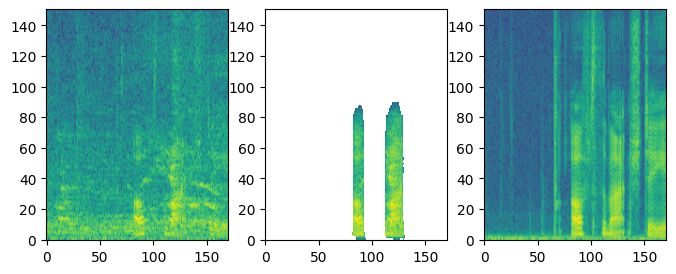

In [56]:
idx = np.random.randint(10)
plt.figure(figsize=(8,3))
plt.subplot(131)
plt.imshow(noisy_spec[idx,:,:].to('cpu').abs().log().mT.numpy(),origin='lower', aspect="auto")
plt.subplot(132)
plt.imshow(enhanced_spec[idx,:,:].to('cpu').abs().log().mT.detach().numpy(),origin='lower', aspect="auto")
plt.subplot(133)
plt.imshow(clean_spec[idx,:,:].to('cpu').abs().log().mT.numpy(),origin='lower', aspect="auto")
plt.show()

import IPython
IPython.display.display(IPython.display.Audio(noisy_batch[idx,:].detach().numpy(),rate=int(sr)))
IPython.display.display(IPython.display.Audio(enhanced_batch[idx,:].detach().numpy(),rate=int(sr)))
IPython.display.display(IPython.display.Audio(clean_batch[idx,:],rate=int(sr)))